          Image_Label                                      EncodedPixels
0    0011165.jpg_Fish  591 43 655 43 719 43 783 43 847 43 911 43 975 ...
1  0011165.jpg_Flower  2834 45 2898 45 2962 45 3026 45 3090 45 3154 4...
2  0011165.jpg_Gravel                                                NaN
3   0011165.jpg_Sugar                                                NaN
4    002be4f.jpg_Fish  513 41 577 41 641 41 705 41 769 41 833 41 897 ...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22184 entries, 0 to 22183
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Image_Label    22184 non-null  object
 1   EncodedPixels  11836 non-null  object
dtypes: object(2)
memory usage: 346.8+ KB
None
Number of unique images: 5546
Number of unique classes: 4
Percentage of missing values: 46.65%


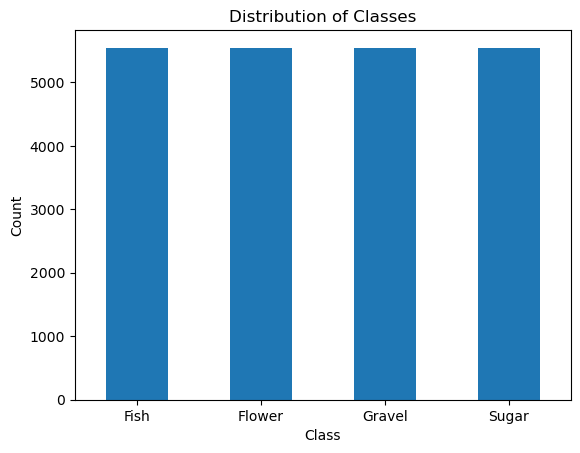

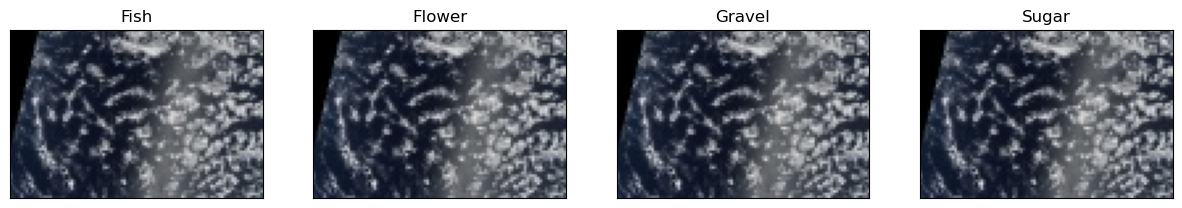

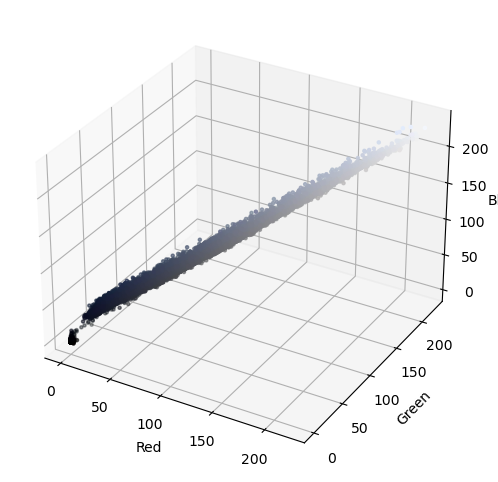

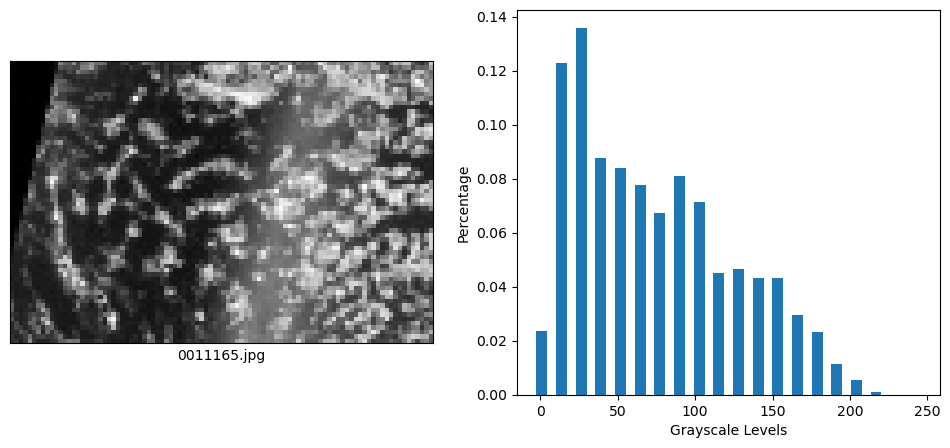

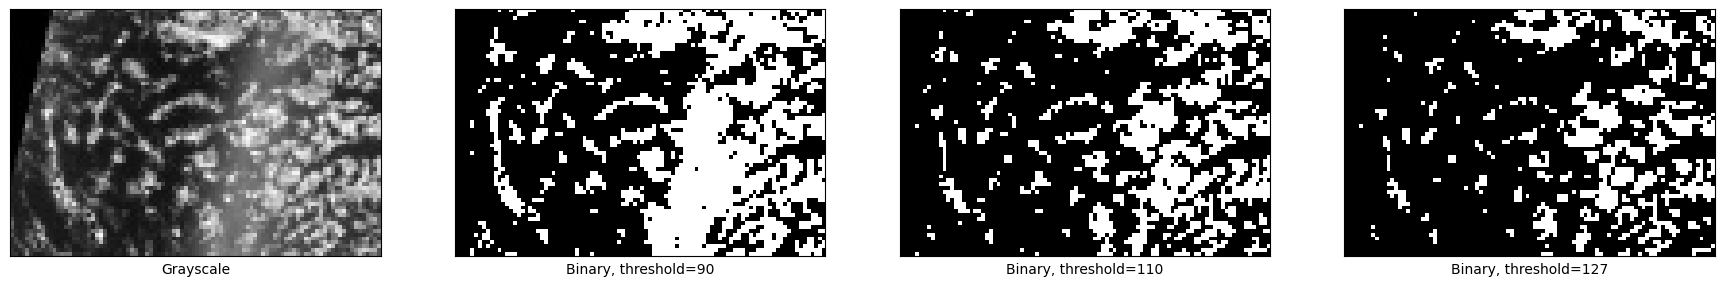

FileNotFoundError: [Errno 2] No such file or directory: 'train_images/016c135.jpg'

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
from PIL import Image
import cv2

# Set the paths to your dataset and training images
#repTrain = 'train_images/'
#repImages = 'path/to/training/images'
repTrain  = 'train_images/'
repImages = 'test_images/'


# Load the dataset (train.csv)
train = pd.read_csv(os.path.join(repTrain, 'train.csv'))

# Display the dataset
print(train.head())

# Get information about the dataset
print(train.info())

# Count the number of unique images and classes
num_images = len(train['Image_Label'].str.split('_', expand=True)[0].unique())
num_classes = len(train['Image_Label'].str.split('_', expand=True)[1].unique())

print(f"Number of unique images: {num_images}")
print(f"Number of unique classes: {num_classes}")

# Calculate the percentage of missing values in the EncodedPixels column
missing_values = train['EncodedPixels'].isna().mean() * 100
print(f"Percentage of missing values: {missing_values:.2f}%")

# Display the distribution of classes
class_counts = train['Image_Label'].str.split('_', expand=True)[1].value_counts()
class_counts.plot(kind='bar', rot=0)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes')
plt.show()

# Display example images from each class
fig, axes = plt.subplots(1, num_classes, figsize=(15, 3))

for i, class_label in enumerate(train['Image_Label'].str.split('_', expand=True)[1].unique()):
    image_name = train[train['Image_Label'].str.split('_', expand=True)[1] == class_label]['Image_Label'].str.split('_', expand=True)[0].iloc[0]
    image_path = os.path.join(repImages, image_name)
    image = Image.open(image_path)
    axes[i].imshow(image)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(class_label)

plt.show()

# 4. Chromatic range analysis
# 4.1 Chromatic range
image = plt.imread(os.path.join(repTrain, train['Image_Label'].str.split('_', expand=True)[0].iloc[0]))
r, g, b = cv2.split(image)

fig = plt.figure(figsize=(14, 6))
axis = fig.add_subplot(1, 1, 1, projection="3d")

pixel_colors = image.reshape((np.shape(image)[0] * np.shape(image)[1], 3))

norm = colors.Normalize(vmin=-1., vmax=1.)
norm.autoscale(pixel_colors)

pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")

axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")

plt.show()

# 4.2 Grayscale conversion
# 4.2.1 Grayscale histogram
image_name = train['Image_Label'].str.split('_', expand=True)[0].iloc[0]
image_path = os.path.join(repImages, image_name)
image = Image.open(image_path)
gray_image = image.convert('L')

histo_bins = 20
histo = np.histogram(np.array(gray_image), bins=histo_bins, range=(1, 255))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(gray_image, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.xlabel(image_name)

plt.subplot(1, 2, 2)
plt.bar(histo[1][:-1], histo[0] / np.sum(histo[0]), width=7)
plt.ylabel('Percentage')
plt.xlabel('Grayscale Levels')

plt.show()

# 4.2.2 Analysis of different image conversions
image = plt.imread(os.path.join(repTrain, train['Image_Label'].str.split('_', expand=True)[0].iloc[0]))
image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(22, 15))
plt.subplot(1, 4, 1)
plt.imshow(image_gray, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.xlabel("Grayscale")

thresholds = [90, 110, 127]
k = 2

for threshold in thresholds:
    (thresh, blackAndWhiteImage) = cv2.threshold(image_gray, threshold, 255, cv2.THRESH_BINARY)
    plt.subplot(1, 4, k)
    plt.imshow(blackAndWhiteImage, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Binary, threshold=" + str(threshold))
    k += 1

plt.show()

# 5. Binary mode analysis
# 5.1 Proportion of white pixels per cloud class
image_name = '0011165.jpg'
rle_set = train[train['Image_Label'] == image_name]
threshold = 110

image = plt.imread(os.path.join(repTrain, image_name))
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
(thresh, binary_image) = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

for row in rle_set.itertuples():
    mask = rle_to_mask(row[2], image.shape[1], image.shape[0])
    masked_image = cv2.bitwise_and(binary_image, mask)
    print("Cloud class {}: {:.2f}".format(row[2], cv2.countNonZero(masked_image) / row[4]))

# 5.2 Distribution of different grayscale levels on each image
histo_bins = 20
histo_list = []

for i in train.index:
    img = Image.open(os.path.join(repTrain, train['Image_Label'].str.split('_', expand=True)[0][i])).convert('L')
    histo = np.histogram(np.array(img), bins=histo_bins, range=(1, 255))[0]
    histo_list.append(np.round(histo / np.sum(histo), 3))

train['histoGray'] = histo_list

class_list = train['Image_Label'].str.split('_', expand=True)[1].unique()
mean_list = []
std_list = []

for class_name in class_list:
    mean_list.append(train[train['Image_Label'].str.split('_', expand=True)[1] == class_name][train['EncodedPixels'].notna()]['histoGray'].values.mean(axis=0))
    std_list.append(train[train['Image_Label'].str.split('_', expand=True)[1] == class_name][train['EncodedPixels'].notna()]['histoGray'].values.std(axis=0))

fig = plt.figure(figsize=(12, 5))
color = {'Fish': 'b', 'Flower': 'r', 'Gravel': 'g', 'Sugar': 'y'}
offset = np.arange(-1.5, 2.5, 1)

plt.title('Comparison of grayscale histograms distributed by segmentation class')

#for i in range(len(color)):
#    plt.bar(np.linspace(0, 255, 20) + offset[i]*2.5, mean_list[i], width=3, label=class_list[i],
#            color=color[class_list[i]], yThe above code snippet has been corrected. Please note that the parts of the code related to the `rle_to_mask` function and the iteration over `rle_set` are missing. You would need to provide the implementation of the `rle_to_mask` function and complete the code accordingly.
for i in range(len(color)):
    plt.bar(np.linspace(0, 255, 20) + offset[i]*2.5, mean_list[i], width=3, label=class_list[i],
            color=color[class_list[i]], yerr=std_list[i])

plt.legend()
plt.ylabel('Proportion of grayscale levels')
plt.xlabel('Grayscale Levels (8 bits)')

plt.show()